In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
%matplotlib inline

# Topic Modelling
To compare the effectiveness of the coded reviews vs. the valence-aware reviews, I'll repeat the same topic modelling steps. 

<br><br>
The handler below helps me capture some metrics that gensim calculates during training runs but does not output or save in any way. In particular, I need to capture:
* Perplexity - this is a measure of how likely it is that the topic model (as it currently stands) generated a given text sample. So, we expect to see perplexity decreasing over training runs; otherwise the model is not fitting the documents well. However, perplexity is meaningful only for in-model tuning and comparisons. 
* Topic difference - this is a measure of how much the topics changed over the last training iteration. As topic difference approaches zero, it indicates that the model is converging. 
* Per-word bound - 

In [2]:
from gensim import corpora
import gensim, logging, io, os
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
handler = logging.FileHandler('training_output.log')


# The handler above is somthing I needed with respect to logging.
# Gensim performs various calculations while training the LDA model that I am using, but the only way to see them
# is in the logging outputs.
# Specifically, I need to capture the perplexity values during training to verify that perplexity is decreasing.
# This metric is needed to compare models and to do hyperparameter tuning. 


# The following blog post was helpful to me in figure out how to make the log handler I needed.
# https://fangpenlin.com/posts/2012/08/26/good-logging-practice-in-python/



In [11]:
df = pd.read_csv('reviews_subset.csv', index_col=0)
df.head(2)

ProductId          UserId   ProfileName  HelpfulnessNumerator  \
0  B000KV61FC  A1Y1YYH71TPYC6   thefinfan54                     2   
1  B000KV61FC  A1SLLKDKCZ5IPL  C. Guariglia                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1222905600   
1                       2      2  1221091200   

                             Summary  \
0  The best dog toy I ever bought :)   
1           Buried Treasure Forever!   

                                                Text  review_length  \
0  I have two smaller dogs and they absolutely lo...            492   
1  The idea is basically a good one, however, my ...            307   

                         ...                         Valence Fit  \
0                        ...                            0.433204   
1                        ...                            0.728594   

                                        lemmas_clean  \
0  ['two', 'small', 'dog', 'absolutely', 'love', ...   
1  ['idea', 'basically', 'good', 'one', 'however'...   

                                      lemmas_vanilla  \
0  ['i', 'have', 'two', 'small', 'dog', 'and', 't...   
1  ['the', 'idea', 'be', 'basically', 'a', 'good'...   

                                       clean_vanilla  \
0  two small dog absolutely love tug jug many us ...   
1  idea basically good one however large papillon...   

                                    vanilla_stripped  \
0  two small dog absolutely love tug jug many us ...   
1  idea basically good one however large papillon...   

                                      coded_stripped  \
0  two small dog absolutely love GOODREVIEW tug j...   
1  idea basically good GOODREVIEW one however lar...   

                                    valence_stripped  \
0  two small dog absolutely love VGOODREVIEW tug ...   
1  idea basically good GOODREVIEW one however lar...   

                                     clean_vanilla_x  \
0  two small dog absolutely love tug jug many us ...   
1  idea basically good one however large papillon...   

                                       clean_coded_x  \
0  two small dog absolutely love GOODREVIEW tug j...   
1  idea basically good GOODREVIEW one however lar...   

                                     clean_valence_x  
0  two small dog absolutely love VGOODREVIEW tug ...  
1  idea basically good GOODREVIEW one however lar...  

[2 rows x 44 columns]

In [12]:
# get the count of reviews present for each product
review_counts = df['ProductId'].value_counts().sort_values()
review_counts.tail(12)

B002IEZJMA    487
B006MONQMC    491
B005ZBZLT4    506
B003GTR8IO    530
B005K4Q34S    541
B0013A0QXC    542
B000NMJWZO    542
B000KV61FC    556
B001EO5Q64    567
B0026RQTGE    630
Name: ProductId, dtype: int64

In [13]:
# For the LDA model, I'd like to filter out the top 3 most frequently used tokens in the corpus
# For most products, the most frequent tokens  refer to the product itself in a generic way and also contain what we might consider stop words
# but didn't want to remove earlier because they are needed for part-of-speech tagging
# (e.g., "product," "coconut," "oil" as well as "have," "be," etc.)
# this helper function is a slight modification of one of gensim's built-in methods -
# I don't want to remove the codewords I've inserted, and those also end up in the top 3 quite often, 
# particularly after 

def remove_freq(dictionary, n):
    logger = logging.getLogger('gensim.corpora.dictionary')
    save = set(['GOODREVIEW', 'BADREVIEW', 'VGOODREVIEW', 'VBADREVIEW'])
    most_frequent_ids = (v for v in (dictionary.token2id).values() if dictionary[v] not in save)
    most_frequent_ids = sorted(most_frequent_ids, key=dictionary.dfs.get, reverse=True)
    most_frequent_ids = most_frequent_ids[:n]
    # do the actual filtering, then rebuild dictionary to remove gaps in ids
    most_frequent_words = [(dictionary[idx], dictionary.dfs.get(idx, 0)) for idx in most_frequent_ids]
    logger.info("discarding %i tokens: %s...", len(most_frequent_ids), most_frequent_words[:10])

    dictionary.filter_tokens(bad_ids=most_frequent_ids)
    logger.info("resulting dictionary: %s", dictionary)

# the next few helper functions deal with extracting metrics of interest from gensim's logger, 
# which are being dumped into a log file as training runs
# I am capturing bounds, perplexity, and per-word topic differences
    
    
import itertools
# thanks to these SO answers https://stackoverflow.com/questions/6213063/python-read-next
# and https://stackoverflow.com/questions/5434891/iterate-a-list-as-pair-current-next-in-python
# for showing a way to deal with lines of a file in groups of three
def threes(iterator):
    "s -> (s0,s1,s2), (s1,s2,s3), (s2, s3, s4), ..."
    a, b, c = itertools.tee(iterator, 3)
    next(b, None)
    next(c, None)
    next(c, None)
    return zip(a, b, c)

def capture_logs(): # capture the perplexity, per-word bound, and topic difference values from the logger and save
    perplexity_log = []
    perplex = {}
    bounds = {}
    diff = {}
    with open("training_output.log", 'r') as f:
        for line in f:
            if re.match("|".join([r'.*topic diff.*', r'.*per-word.*', r'.*PROGRESS.*']), line):
                perplexity_log.append(line)
    for a, b, c in threes(perplexity_log): 
        if re.match(r'.*PROGRESS.*', a):
            pass_val = int(re.search(r'\d*, at', a).group(0).split(',')[0])
            if re.match(r'.*topic diff.*', b):
                d = float(re.search(r'\d*\.\d*', b).group(0).split()[0])
                diff[pass_val] = d
            if re.match(r'.*per-word.*', b): # these may show up in the second line of the group as well
                b = float(re.search(r'.\d*\.\d* per', b).group(0).split()[0])
                p = float(re.search(r'\d*\.\d perplexity', b).group(0).split()[0])
                perplex[pass_val] = p
                bounds[pass_val] = b
            if re.match(r'.*per-word.*', c):
                b = float(re.search(r'.\d*\.\d* per', c).group(0).split()[0])
                p = float(re.search(r'\d*\.\d perplexity', c).group(0).split()[0])
                perplex[pass_val] = p
                bounds[pass_val] = b
    return bounds, perplex, diff

def perplexity_decreasing(perplex): #checks if the perplexity decreased during the last two training passes
    passes = sorted(perplex.keys())
    start = passes[-2]
    end = passes[-1]
    if perplex[start] > perplex[end]:
        return True
    else:
        return False

In [6]:
# this function runs trains an LDA model for a single product, 
# constructing any number of topics over any number of passes
def run_lda(product, n_topics, n_passes, texts, save_path):
    """
    This function trains an LDA model fo a single product, 
    constructing any number of topics over any number of training passes.
    product: the string product ID
    n_topics: number of topics desired
    n_passes: number of training passes to make
    texts: the corpus to use (column name from the main dataframe)
    save_path: where to save the model outputs
    returns a dataframe with the results of the training 
    """
    os.remove('training_output.log')
    logger = logging.getLogger('gensim.models.ldamodel')
    handler = logging.FileHandler('training_output.log')
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s : %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    data = df[df['ProductId']==product]
    texts = data[texts].str.split()
    dictionary = corpora.Dictionary(texts)
    remove_freq(dictionary, 3)
    corpus = [dictionary.doc2bow(text) for text in texts]
    corpora.MmCorpus.serialize('/tmp/corpus.mm', corpus)
    mm = corpora.MmCorpus('/tmp/corpus.mm')
    chunk_size = review_counts[product]/3
    lda = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=n_topics, update_every=1, chunksize=chunk_size, passes=n_passes)
    bounds, perplex, diff = capture_logs()
    results = pd.DataFrame(index=[product], data={'num_topics': n_topics, 'chunk': chunk_size, 'passes': n_passes})
    results['per-word bounds'] = [bounds]
    results['perplexity'] = [perplex]
    results['topic diff'] = [diff]
    p = sorted(perplex.keys())
    end = p[-1]
    results['final perplexity'] = perplex[end]
    d = sorted(diff.keys())
    end = p[-1]
    results['final topic diff'] = diff[end]
    if perplexity_decreasing:
        results['perplexity decreasing'] = True
    else: 
        results['perplexity_decreasing'] = False
    for n in range(0,n_topics):
        topic = lda.show_topic(n, 20)
        results['topic {}'.format(n)] = [topic]
    lda.save('./{}/{}'.format(save_path, product))
    lda.clear()
    return results


In [14]:
# get a couple product groups to work with - the 10 and 20 products with the largest number of reviews
top_ten = review_counts.tail(10).index.values
top_twenty = review_counts.tail(20).index.values

In [8]:
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# create a dataframe to house the results of the model tuning from an initial grid search
valence_gs_results = pd.DataFrame(columns=['product', 'num_topics', 'chunk', 'passes', 'per-word bounds', 'perplexity', 'topic diff',
                                  'final perplexity', 'final topic diff', 'perplexity decreasing', 'coherence'])

# for each of the top ten products, grid search over a combination of n_passes and n_topics 
# save the parameter combinations (and saved model) of the model with the highest coherence score
for product in top_ten:
    output = tune_lda(product=product, n_passes=[50, 80], n_topics=[6, 10, 12], save_path='valence_outputs',\
                      input_text='clean_valence')
    valence_gs_results = save_best_valence(output, valence_gs_results)

2018-04-23 23:18:13,806 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-23 23:18:13,898 : INFO : built Dictionary(2971 unique tokens: ['subject', 'dreg', 'tastes', 'sommelier', 'okay']...) from 487 documents (total 41120 corpus positions)
2018-04-23 23:18:13,911 : INFO : discarding 10 tokens: [('be', 478), ('coffee', 444), ('not', 397), ('drink', 372), ('have', 329), ('like', 325), ('taste', 316), ('do', 278), ('flavor', 232), ('good', 211)]...
2018-04-23 23:18:13,918 : INFO : resulting dictionary: Dictionary(2961 unique tokens: ['subject', 'dreg', 'tastes', 'sommelier', 'okay']...)
2018-04-23 23:18:13,982 : INFO : storing corpus in Matrix Market format to /tmp/corpus.mm
2018-04-23 23:18:13,986 : INFO : saving sparse matrix to /tmp/corpus.mm
2018-04-23 23:18:13,987 : INFO : PROGRESS: saving document #0
2018-04-23 23:18:14,077 : INFO : saved 487x2961 matrix, density=1.602% (23097/1442007)
2018-04-23 23:18:14,078 : INFO : saving MmCorpus index to /tmp/corpus.mm.ind

training LDA with 6 topics over 50 passes


2018-04-23 23:18:14,336 : INFO : running online (multi-pass) LDA training, 6 topics, 50 passes over the supplied corpus of 487 documents, updating model once every 162 documents, evaluating perplexity every 487 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-23 23:18:14,396 : INFO : PROGRESS: pass 0, at document #162/487
2018-04-23 23:18:15,193 : INFO : merging changes from 162 documents into a model of 487 documents
2018-04-23 23:18:15,283 : INFO : topic #0 (0.167): 0.065*"GOODREVIEW" + 0.043*"BADREVIEW" + 0.023*"VGOODREVIEW" + 0.014*"espresso" + 0.011*"strong" + 0.010*"illy" + 0.008*"most" + 0.008*"just" + 0.008*"would" + 0.007*"too"
2018-04-23 23:18:15,285 : INFO : topic #1 (0.167): 0.090*"GOODREVIEW" + 0.043*"BADREVIEW" + 0.025*"VGOODREVIEW" + 0.015*"sugar" + 0.014*"so" + 0.012*"espresso" + 0.011*"sweet" + 0.009*"too" + 0.009*"illy" + 0.007*"only"
2018-04-23 23:18:15,287 : INFO : topic #2 (0.167): 0.067*"BADREVIEW" + 0.053*"GOODREVIEW" + 0.040*"VGOODREVIEW

training LDA with 10 topics over 50 passes


2018-04-24 12:58:02,152 : INFO : running online (multi-pass) LDA training, 10 topics, 50 passes over the supplied corpus of 556 documents, updating model once every 185 documents, evaluating perplexity every 556 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-24 12:58:02,211 : INFO : PROGRESS: pass 0, at document #185/556
2018-04-24 12:58:03,269 : INFO : merging changes from 185 documents into a model of 556 documents
2018-04-24 12:58:03,333 : INFO : topic #0 (0.100): 0.053*"GOODREVIEW" + 0.048*"BADREVIEW" + 0.021*"VGOODREVIEW" + 0.015*"would" + 0.011*"one" + 0.009*"love" + 0.008*"lab" + 0.008*"old" + 0.008*"keep" + 0.008*"good"
2018-04-24 12:58:03,335 : INFO : topic #7 (0.100): 0.043*"BADREVIEW" + 0.039*"GOODREVIEW" + 0.015*"VGOODREVIEW" + 0.011*"large" + 0.011*"buy" + 0.010*"so" + 0.010*"minute" + 0.010*"bottle" + 0.009*"play" + 0.009*"keep"
2018-04-24 12:58:03,337 : INFO : topic #1 (0.100): 0.087*"GOODREVIEW" + 0.025*"VGOODREVIEW" + 0.019*"BADREVIEW" + 0.01

training LDA with 12 topics over 50 passes


2018-04-24 13:55:58,949 : INFO : running online (multi-pass) LDA training, 12 topics, 50 passes over the supplied corpus of 567 documents, updating model once every 189 documents, evaluating perplexity every 567 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-24 13:55:59,000 : INFO : PROGRESS: pass 0, at document #189/567
2018-04-24 13:56:00,001 : INFO : merging changes from 189 documents into a model of 567 documents
2018-04-24 13:56:00,086 : INFO : topic #7 (0.083): 0.063*"GOODREVIEW" + 0.055*"VGOODREVIEW" + 0.046*"BADREVIEW" + 0.014*"hair" + 0.011*"taste" + 0.011*"smell" + 0.011*"love" + 0.008*"skin" + 0.008*"make" + 0.007*"jar"
2018-04-24 13:56:00,088 : INFO : topic #5 (0.083): 0.074*"GOODREVIEW" + 0.039*"BADREVIEW" + 0.036*"VGOODREVIEW" + 0.008*"well" + 0.008*"price" + 0.008*"brand" + 0.007*"also" + 0.006*"nutiva" + 0.006*"one" + 0.006*"like"
2018-04-24 13:56:00,090 : INFO : topic #1 (0.083): 0.040*"VGOODREVIEW" + 0.038*"BADREVIEW" + 0.035*"GOODREVIEW" + 

training LDA with 12 topics over 80 passes


2018-04-24 13:58:21,002 : INFO : running online (multi-pass) LDA training, 12 topics, 80 passes over the supplied corpus of 567 documents, updating model once every 189 documents, evaluating perplexity every 567 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-24 13:58:21,053 : INFO : PROGRESS: pass 0, at document #189/567
2018-04-24 13:58:22,064 : INFO : merging changes from 189 documents into a model of 567 documents
2018-04-24 13:58:22,152 : INFO : topic #7 (0.083): 0.063*"GOODREVIEW" + 0.055*"VGOODREVIEW" + 0.046*"BADREVIEW" + 0.014*"hair" + 0.011*"taste" + 0.011*"smell" + 0.011*"love" + 0.008*"skin" + 0.008*"make" + 0.007*"jar"
2018-04-24 13:58:22,154 : INFO : topic #5 (0.083): 0.074*"GOODREVIEW" + 0.039*"BADREVIEW" + 0.036*"VGOODREVIEW" + 0.008*"well" + 0.008*"price" + 0.008*"brand" + 0.007*"also" + 0.006*"nutiva" + 0.006*"one" + 0.006*"like"
2018-04-24 13:58:22,156 : INFO : topic #1 (0.083): 0.040*"VGOODREVIEW" + 0.038*"BADREVIEW" + 0.035*"GOODREVIEW" + 

training LDA with 6 topics over 80 passes


2018-04-24 14:03:55,523 : INFO : running online (multi-pass) LDA training, 6 topics, 80 passes over the supplied corpus of 630 documents, updating model once every 210 documents, evaluating perplexity every 630 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-24 14:03:55,558 : INFO : PROGRESS: pass 0, at document #210/630
2018-04-24 14:03:56,536 : INFO : merging changes from 210 documents into a model of 630 documents
2018-04-24 14:03:56,582 : INFO : topic #2 (0.167): 0.066*"GOODREVIEW" + 0.057*"VGOODREVIEW" + 0.028*"BADREVIEW" + 0.016*"great" + 0.015*"price" + 0.013*"one" + 0.012*"so" + 0.010*"like" + 0.009*"good" + 0.009*"s"
2018-04-24 14:03:56,584 : INFO : topic #3 (0.167): 0.046*"GOODREVIEW" + 0.040*"VGOODREVIEW" + 0.038*"BADREVIEW" + 0.014*"one" + 0.013*"like" + 0.013*"so" + 0.013*"give" + 0.012*"chew" + 0.012*"good" + 0.010*"year"
2018-04-24 14:03:56,587 : INFO : topic #1 (0.167): 0.028*"VGOODREVIEW" + 0.014*"great" + 0.012*"size" + 0.010*"one" + 0.008*"s

training LDA with 10 topics over 80 passes


2018-04-24 14:42:35,020 : INFO : running online (multi-pass) LDA training, 10 topics, 80 passes over the supplied corpus of 630 documents, updating model once every 210 documents, evaluating perplexity every 630 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-24 14:42:35,056 : INFO : PROGRESS: pass 0, at document #210/630
2018-04-24 14:42:36,109 : INFO : merging changes from 210 documents into a model of 630 documents
2018-04-24 14:42:36,163 : INFO : topic #5 (0.100): 0.062*"GOODREVIEW" + 0.044*"BADREVIEW" + 0.026*"VGOODREVIEW" + 0.016*"so" + 0.010*"time" + 0.010*"than" + 0.009*"would" + 0.009*"like" + 0.009*"breath" + 0.009*"give"
2018-04-24 14:42:36,166 : INFO : topic #6 (0.100): 0.046*"GOODREVIEW" + 0.037*"BADREVIEW" + 0.026*"VGOODREVIEW" + 0.023*"one" + 0.014*"chew" + 0.013*"really" + 0.011*"so" + 0.010*"would" + 0.009*"dental" + 0.008*"good"
2018-04-24 14:42:36,169 : INFO : topic #3 (0.100): 0.047*"GOODREVIEW" + 0.045*"BADREVIEW" + 0.040*"VGOODREVIEW" + 0

In [22]:
# save off the results with the best model (highest coherence) for each product
# examine the results
valence_gs_results.to_csv('valence_gs_results.csv')
valence_gs_results[['product','coherence', 'num_topics', 'passes']]

product  coherence num_topics passes
0  B002IEZJMA   0.469544         12     80
1  B006MONQMC   0.531322         10     80
2  B005ZBZLT4   0.436334          6     80
3  B003GTR8IO   0.460091         12     80
4  B005K4Q34S   0.433501          6     80
5  B000NMJWZO   0.472968         10     80
6  B0013A0QXC   0.400984         12     80
7  B000KV61FC   0.437343          6     80
8  B001EO5Q64   0.444206         12     80
9  B0026RQTGE   0.428408          6     80

In [10]:
valence_gs_results = pd.read_csv('valence_gs_results.csv')
valence_gs_results[['product','coherence', 'num_topics', 'passes']]

product  coherence  num_topics  passes
0   B002IEZJMA   0.469544          12      80
1   B006MONQMC   0.531322          10      80
2   B005ZBZLT4   0.436334           6      80
3   B003GTR8IO   0.460091          12      80
4   B005K4Q34S   0.433501           6      80
5   B000NMJWZO   0.472968          10      80
6   B0013A0QXC   0.400984          12      80
7   B000KV61FC   0.437343           6      80
8   B001EO5Q64   0.444206          12      80
9   B0026RQTGE   0.428408           6      80
10  B002IEZJMA   0.472952          11      80
11  B003GTR8IO   0.471875          13      80
12  B005K4Q34S   0.468767           5      80
13  B000KV61FC   0.453969           8      80
14  B001EO5Q64   0.464751          13      80
15  B0026RQTGE   0.448537           7      80
16  B0013A0QXC   0.417092          15      80

Now, a little further manual tuning to try to get each of the products up to the 0.5 threshold. I repeated the grid search process for products where the coherence was well below 0.5 or where it decreased between the baseline training and the first iteration of grid search. 

In [ ]:
output = tune_lda(product='B002IEZJMA', n_passes=[80, 200], n_topics=[13], save_path='valence_outputs',\
                  input_text='clean_valence')


2018-04-30 14:52:43,486 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-30 14:52:43,572 : INFO : built Dictionary(2971 unique tokens: ['subject', 'dreg', 'tastes', 'sommelier', 'okay']...) from 487 documents (total 41120 corpus positions)
2018-04-30 14:52:43,587 : INFO : discarding 10 tokens: [('be', 478), ('coffee', 444), ('not', 397), ('drink', 372), ('have', 329), ('like', 325), ('taste', 316), ('do', 278), ('flavor', 232), ('good', 211)]...
2018-04-30 14:52:43,592 : INFO : resulting dictionary: Dictionary(2961 unique tokens: ['subject', 'dreg', 'tastes', 'sommelier', 'okay']...)
2018-04-30 14:52:43,662 : INFO : storing corpus in Matrix Market format to /tmp/corpus.mm
2018-04-30 14:52:43,664 : INFO : saving sparse matrix to /tmp/corpus.mm
2018-04-30 14:52:43,665 : INFO : PROGRESS: saving document #0
2018-04-30 14:52:43,768 : INFO : saved 487x2961 matrix, density=1.602% (23097/1442007)
2018-04-30 14:52:43,770 : INFO : saving MmCorpus index to /tmp/corpus.mm.ind

training LDA with 13 topics over 80 passes


2018-04-30 14:52:44,355 : INFO : running online (multi-pass) LDA training, 13 topics, 80 passes over the supplied corpus of 487 documents, updating model once every 162 documents, evaluating perplexity every 487 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-30 14:52:44,414 : INFO : PROGRESS: pass 0, at document #162/487
2018-04-30 14:52:45,274 : INFO : merging changes from 162 documents into a model of 487 documents
2018-04-30 14:52:45,379 : INFO : topic #11 (0.077): 0.082*"GOODREVIEW" + 0.061*"VGOODREVIEW" + 0.047*"BADREVIEW" + 0.015*"strong" + 0.012*"espresso" + 0.010*"so" + 0.010*"nice" + 0.010*"sweet" + 0.009*"would" + 0.008*"sugar"
2018-04-30 14:52:45,383 : INFO : topic #5 (0.077): 0.065*"BADREVIEW" + 0.036*"GOODREVIEW" + 0.017*"VGOODREVIEW" + 0.014*"make" + 0.012*"sugar" + 0.011*"espresso" + 0.011*"illy" + 0.010*"try" + 0.009*"issimo" + 0.009*"so"
2018-04-30 14:52:45,387 : INFO : topic #6 (0.077): 0.058*"GOODREVIEW" + 0.057*"BADREVIEW" + 0.012*"so" + 0

In [128]:
output

chunk  coherence  final perplexity  final topic diff num_topics  \
0  162.333333   0.470600              19.8          0.046251         13   
0  162.333333   0.472193              19.4          0.029827         13   

  passes                                    per-word bounds  \
0     80  {0: -8.339, 1: -5.742, 2: -5.076, 3: -4.698, 4...   
0    200  {0: -8.339, 1: -5.742, 2: -5.076, 3: -4.698, 4...   

                                          perplexity perplexity decreasing  \
0  {0: 323.9, 1: 53.5, 2: 33.7, 3: 26.0, 4: 24.3,...                  True   
0  {0: 323.9, 1: 53.5, 2: 33.7, 3: 26.0, 4: 24.3,...                  True   

      product                        ...                          \
0  B002IEZJMA                        ...                           
0  B002IEZJMA                        ...                           

                                            topic 12  \
0  [(accord, 0.0117308), (nasty, 0.0102413), (eat...   
0  [(accord, 0.0116054), (nasty, 0.010147), (eat,...   

                                             topic 2  \
0  [(BADREVIEW, 0.0805537), (GOODREVIEW, 0.023593...   
0  [(BADREVIEW, 0.0789055), (love, 0.016668), (wo...   

                                             topic 3  \
0  [(could, 0.0135186), (latte, 0.0117062), (road...   
0  [(could, 0.0126015), (road, 0.0123119), (latte...   

                                             topic 4  \
0  [(GOODREVIEW, 0.160473), (okay, 0.0406086), (B...   
0  [(GOODREVIEW, 0.159736), (okay, 0.0405066), (B...   

                                             topic 5  \
0  [(house, 0.0142888), (benefit, 0.0117669), (ch...   
0  [(house, 0.0142997), (benefit, 0.0118432), (ch...   

                                             topic 6  \
0  [(dunkin, 0.00954651), (donut, 0.00884744), (w...   
0  [(dunkin, 0.0101724), (donut, 0.00941873), (wa...   

                                             topic 7  \
0  [(drop, 0.00996999), (whole, 0.00900121), (slu...   
0  [(drop, 0.0100046), (whole, 0.00898729), (slum...   

                                             topic 8  \
0  [(ounce, 0.0283707), (company, 0.018661), (pro...   
0  [(ounce, 0.0318265), (company, 0.018511), (fir...   

                                             topic 9  \
0  [(GOODREVIEW, 0.114465), (BADREVIEW, 0.0533147...   
0  [(GOODREVIEW, 0.11371), (BADREVIEW, 0.0544296)...   

                                          topic diff  
0  {0: 0.860996, 1: 0.553062, 2: 0.449808, 3: 0.3...  
0  {0: 0.860996, 1: 0.553062, 2: 0.449808, 3: 0.3...  

[2 rows x 24 columns]

In [84]:
valence_gs_results = save_best_valence(output, valence_gs_results)
valence_gs_results.to_csv('valence_gs_results.csv')

2018-04-26 13:52:07,076 : INFO : loading LdaModel object from ./valence_outputs/B0013A0QXC_15_80
2018-04-26 13:52:07,083 : INFO : loading expElogbeta from ./valence_outputs/B0013A0QXC_15_80.expElogbeta.npy with mmap=None
2018-04-26 13:52:07,088 : INFO : setting ignored attribute state to None
2018-04-26 13:52:07,089 : INFO : setting ignored attribute id2word to None
2018-04-26 13:52:07,091 : INFO : setting ignored attribute dispatcher to None
2018-04-26 13:52:07,093 : INFO : loaded ./valence_outputs/B0013A0QXC_15_80
2018-04-26 13:52:07,095 : INFO : loading LdaState object from ./valence_outputs/B0013A0QXC_15_80.state
2018-04-26 13:52:07,104 : INFO : loaded ./valence_outputs/B0013A0QXC_15_80.state
2018-04-26 13:52:07,114 : INFO : saving LdaState object under ./valence_outputs/final_models/B0013A0QXC_15_80.state, separately None
2018-04-26 13:52:07,121 : INFO : saved ./valence_outputs/final_models/B0013A0QXC_15_80.state
2018-04-26 13:52:07,125 : INFO : saving LdaModel object under ./vale

best results for product B0013A0QXC:
index                                                                    0
chunk                                                              180.667
coherence                                                         0.417092
final perplexity                                                      22.1
final topic diff                                                  0.050586
num_topics                                                              15
passes                                                                  80
per-word bounds          {0: -9.614, 1: -5.637, 2: -5.088, 3: -4.849, 4...
perplexity               {0: 783.8, 1: 49.8, 2: 34.0, 3: 28.8, 4: 26.6,...
perplexity decreasing                                                 True
product                                                         B0013A0QXC
topic 0                  [(leave, 0.0328399), (brewer, 0.0230511), (fla...
topic 1                  [(excellent, 0.0522598), (day, 0.03394

In [77]:
valence_gs_results[['product','coherence', 'num_topics', 'passes']]

product  coherence  num_topics  passes
0   B002IEZJMA   0.469544          12      80
1   B006MONQMC   0.531322          10      80
2   B005ZBZLT4   0.436334           6      80
3   B003GTR8IO   0.460091          12      80
4   B005K4Q34S   0.433501           6      80
5   B000NMJWZO   0.472968          10      80
6   B0013A0QXC   0.400984          12      80
7   B000KV61FC   0.437343           6      80
8   B001EO5Q64   0.444206          12      80
9   B0026RQTGE   0.428408           6      80
10  B002IEZJMA   0.472952          11      80
11  B003GTR8IO   0.471875          13      80
12  B005K4Q34S   0.468767           5      80
13  B000KV61FC   0.453969           8      80
14  B001EO5Q64   0.464751          13      80
15  B0026RQTGE   0.448537           7      80

In [86]:
# create a df to collect the best models from all grid search tuning efforts
valence_final_results = pd.DataFrame(columns=['product', 'num_topics', 'chunk', 'passes', 'per-word bounds', 'perplexity', 'topic diff',
                                  'final perplexity', 'final topic diff', 'perplexity decreasing', 'coherence'])

for product in top_ten:
    output = valence_gs_results[valence_gs_results['product']==product]
    valence_final_results = save_best_valence(output, valence_final_results)

    
                                      

2018-04-26 13:52:31,693 : INFO : loading LdaModel object from ./valence_outputs/B002IEZJMA_11_80
2018-04-26 13:52:31,698 : INFO : loading expElogbeta from ./valence_outputs/B002IEZJMA_11_80.expElogbeta.npy with mmap=None
2018-04-26 13:52:31,701 : INFO : setting ignored attribute state to None
2018-04-26 13:52:31,701 : INFO : setting ignored attribute id2word to None
2018-04-26 13:52:31,702 : INFO : setting ignored attribute dispatcher to None
2018-04-26 13:52:31,703 : INFO : loaded ./valence_outputs/B002IEZJMA_11_80
2018-04-26 13:52:31,704 : INFO : loading LdaState object from ./valence_outputs/B002IEZJMA_11_80.state
2018-04-26 13:52:31,709 : INFO : loaded ./valence_outputs/B002IEZJMA_11_80.state
2018-04-26 13:52:31,715 : INFO : saving LdaState object under ./valence_outputs/final_models/B002IEZJMA_11_80.state, separately None
2018-04-26 13:52:31,718 : INFO : saved ./valence_outputs/final_models/B002IEZJMA_11_80.state
2018-04-26 13:52:31,722 : INFO : saving LdaModel object under ./vale

best results for product B002IEZJMA:
level_0                                                                 10
Unnamed: 0                                                             NaN
product                                                         B002IEZJMA
num_topics                                                              11
chunk                                                              162.333
passes                                                                  80
per-word bounds          {0: -8.298, 1: -5.729, 2: -4.956, 3: -4.731, 4...
perplexity               {0: 314.6, 1: 53.1, 2: 31.0, 3: 26.6, 4: 24.6,...
topic diff               {0: 0.791251, 1: 0.539852, 2: 0.414533, 3: 0.3...
final perplexity                                                      20.6
final topic diff                                                   0.04788
perplexity decreasing                                                 True
coherence                                                      

2018-04-26 13:52:31,844 : INFO : loading expElogbeta from ./valence_outputs/B005ZBZLT4_6_80.expElogbeta.npy with mmap=None
2018-04-26 13:52:31,847 : INFO : setting ignored attribute state to None
2018-04-26 13:52:31,847 : INFO : setting ignored attribute id2word to None
2018-04-26 13:52:31,848 : INFO : setting ignored attribute dispatcher to None
2018-04-26 13:52:31,849 : INFO : loaded ./valence_outputs/B005ZBZLT4_6_80
2018-04-26 13:52:31,850 : INFO : loading LdaState object from ./valence_outputs/B005ZBZLT4_6_80.state
2018-04-26 13:52:31,854 : INFO : loaded ./valence_outputs/B005ZBZLT4_6_80.state
2018-04-26 13:52:31,859 : INFO : saving LdaState object under ./valence_outputs/final_models/B005ZBZLT4_6_80.state, separately None
2018-04-26 13:52:31,863 : INFO : saved ./valence_outputs/final_models/B005ZBZLT4_6_80.state
2018-04-26 13:52:31,866 : INFO : saving LdaModel object under ./valence_outputs/final_models/B005ZBZLT4_6_80, separately ['expElogbeta', 'sstats']
2018-04-26 13:52:31,867 

Final model saved for product B005ZBZLT4 with 6 topics over 80 passes.
best results for product B003GTR8IO:
level_0                                                                 11
Unnamed: 0                                                             NaN
product                                                         B003GTR8IO
num_topics                                                              13
chunk                                                              176.667
passes                                                                  80
per-word bounds          {0: -7.231, 1: -5.549, 2: -5.255, 3: -5.07, 4:...
perplexity               {0: 150.2, 1: 46.8, 2: 38.2, 3: 33.6, 4: 30.0,...
topic diff               {0: 0.8381, 1: 0.513423, 2: 0.369133, 3: 0.313...
final perplexity                                                      21.4
final topic diff                                                  0.043688
perplexity decreasing                                              

2018-04-26 13:52:32,122 : INFO : loading LdaModel object from ./valence_outputs/B000NMJWZO_10_80
2018-04-26 13:52:32,125 : INFO : loading expElogbeta from ./valence_outputs/B000NMJWZO_10_80.expElogbeta.npy with mmap=None
2018-04-26 13:52:32,128 : INFO : setting ignored attribute state to None
2018-04-26 13:52:32,129 : INFO : setting ignored attribute id2word to None
2018-04-26 13:52:32,130 : INFO : setting ignored attribute dispatcher to None
2018-04-26 13:52:32,131 : INFO : loaded ./valence_outputs/B000NMJWZO_10_80
2018-04-26 13:52:32,132 : INFO : loading LdaState object from ./valence_outputs/B000NMJWZO_10_80.state
2018-04-26 13:52:32,136 : INFO : loaded ./valence_outputs/B000NMJWZO_10_80.state
2018-04-26 13:52:32,140 : INFO : saving LdaState object under ./valence_outputs/final_models/B000NMJWZO_10_80.state, separately None
2018-04-26 13:52:32,142 : INFO : saved ./valence_outputs/final_models/B000NMJWZO_10_80.state
2018-04-26 13:52:32,146 : INFO : saving LdaModel object under ./vale

Final model saved for product B000NMJWZO with 10 topics over 80 passes.
best results for product B0013A0QXC:
level_0                                                                 16
Unnamed: 0                                                             NaN
product                                                         B0013A0QXC
num_topics                                                              15
chunk                                                              180.667
passes                                                                  80
per-word bounds          {0: -9.614, 1: -5.637, 2: -5.088, 3: -4.849, 4...
perplexity               {0: 783.8, 1: 49.8, 2: 34.0, 3: 28.8, 4: 26.6,...
topic diff               {0: 0.843579, 1: 0.571174, 2: 0.45468, 3: 0.39...
final perplexity                                                      22.1
final topic diff                                                  0.050586
perplexity decreasing                                             

2018-04-26 13:52:32,374 : INFO : saving LdaState object under ./valence_outputs/final_models/B000KV61FC_8_80.state, separately None
2018-04-26 13:52:32,377 : INFO : saved ./valence_outputs/final_models/B000KV61FC_8_80.state
2018-04-26 13:52:32,381 : INFO : saving LdaModel object under ./valence_outputs/final_models/B000KV61FC_8_80, separately ['expElogbeta', 'sstats']
2018-04-26 13:52:32,382 : INFO : not storing attribute state
2018-04-26 13:52:32,383 : INFO : not storing attribute id2word
2018-04-26 13:52:32,383 : INFO : storing np array 'expElogbeta' to ./valence_outputs/final_models/B000KV61FC_8_80.expElogbeta.npy
2018-04-26 13:52:32,386 : INFO : not storing attribute dispatcher
2018-04-26 13:52:32,388 : INFO : saved ./valence_outputs/final_models/B000KV61FC_8_80
2018-04-26 13:52:32,490 : INFO : loading LdaModel object from ./valence_outputs/B001EO5Q64_13_80
2018-04-26 13:52:32,495 : INFO : loading expElogbeta from ./valence_outputs/B001EO5Q64_13_80.expElogbeta.npy with mmap=None
20

Final model saved for product B000KV61FC with 8 topics over 80 passes.
best results for product B001EO5Q64:
level_0                                                                 14
Unnamed: 0                                                             NaN
product                                                         B001EO5Q64
num_topics                                                              13
chunk                                                                  189
passes                                                                  80
per-word bounds          {0: -8.498, 1: -7.358, 2: -7.103, 3: -7.018, 4...
perplexity               {0: 361.5, 1: 164.0, 2: 137.5, 3: 129.6, 4: 12...
topic diff               {0: 1.951816, 1: 0.624766, 2: 0.378959, 3: 0.2...
final perplexity                                                     114.6
final topic diff                                                  0.038048
perplexity decreasing                                              

In [87]:
valence_final_results.to_csv('valence_final_results.csv')

In [11]:
valence_final_results = pd.read_csv('valence_final_results.csv')
valence_final_results[['product','coherence', 'num_topics', 'passes']]

product  coherence  num_topics  passes
0  B002IEZJMA   0.472952          11      80
1  B006MONQMC   0.531322          10      80
2  B005ZBZLT4   0.436334           6      80
3  B003GTR8IO   0.471875          13      80
4  B005K4Q34S   0.468767           5      80
5  B000NMJWZO   0.472968          10      80
6  B0013A0QXC   0.417092          15      80
7  B000KV61FC   0.453969           8      80
8  B001EO5Q64   0.464751          13      80
9  B0026RQTGE   0.448537           7      80

It was much harder to get to the 0.5 benchmark that I was able to reach with the plain coded inputs. I would guess this is due to a higher degree of complexity being introduced in the form of 4 codewords instead of just two; it will be interesting to compare the topic models with each set of inputs and see if the relationship to star ratings is weaker with the valence-aware codewords. 

In [11]:
valence_final_results = pd.read_csv('valence_final_results.csv')
valence_final_results.set_index('product', inplace=True)
valence_final_results[['num_topics', 'coherence', 'passes', 'final topic diff']]

num_topics  coherence  passes  final topic diff
product                                                    
B002IEZJMA          11   0.472952      80          0.047880
B006MONQMC          10   0.531322      80          0.044337
B005ZBZLT4           6   0.436334      80          0.071379
B003GTR8IO          13   0.471875      80          0.043688
B005K4Q34S           5   0.468767      80          0.080349
B000NMJWZO          10   0.472968      80          0.052892
B0013A0QXC          15   0.417092      80          0.050586
B000KV61FC           8   0.453969      80          0.043500
B001EO5Q64          13   0.464751      80          0.038048
B0026RQTGE           7   0.448537      80          0.040397

For further tuning and to get a more intuitive sense of the topics that are coming out of LDA, the pyLDAvis library has a useful prebuilt visualization for gensim outputs. One thing I'm concerned about is having a lot [too many?] granular topics that are very similar and should perhaps be collapsed into a single theme, and this module helps visualize whether that might be occurring. 

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [14]:
def vis_topics(product, df, final_results):
    data = df[df['ProductId']==product]
    # prepare the corpus
    texts = data['clean_valence'].str.split()
    dictionary = corpora.Dictionary(texts)
    remove_freq(dictionary, 10)
    corpus = [dictionary.doc2bow(text) for text in texts]
    # load in the tuned LDA model for the product
    t = final_results.loc[product, 'num_topics']
    p = final_results.loc[product, 'passes']
    lda = gensim.models.ldamodel.LdaModel.load("./valence_outputs/final_models/{}_{}_{}".format(product, t, p))
    return lda, corpus, dictionary


In [114]:
lda, corpus, dictionary = vis_topics('B001EO5Q64', df, valence_final_results)

2018-04-26 14:40:15,081 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-26 14:40:15,174 : INFO : built Dictionary(3244 unique tokens: ['subject', 'sh', 'tanner', 'anymore', 'discretion']...) from 567 documents (total 35943 corpus positions)
2018-04-26 14:40:15,183 : INFO : discarding 10 tokens: [('be', 504), ('oil', 428), ('use', 395), ('coconut', 390), ('have', 329), ('not', 280), ('great', 231), ('so', 212), ('good', 191), ('do', 189)]...
2018-04-26 14:40:15,191 : INFO : resulting dictionary: Dictionary(3234 unique tokens: ['subject', 'sh', 'tanner', 'anymore', 'quesadilla']...)
2018-04-26 14:40:15,262 : INFO : loading LdaModel object from ./valence_outputs/final_models/B001EO5Q64_13_80
2018-04-26 14:40:15,268 : INFO : loading expElogbeta from ./valence_outputs/final_models/B001EO5Q64_13_80.expElogbeta.npy with mmap=None
2018-04-26 14:40:15,274 : INFO : setting ignored attribute state to None
2018-04-26 14:40:15,275 : INFO : setting ignored attribute id2word to

In [115]:
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      35.979179        1       1  0.308048 -0.032993
7      33.115242        1       2  0.278917  0.018324
2       9.940932        1       3  0.191605  0.195403
6       4.761231        1       4  0.019236 -0.241857
5       4.469712        1       5 -0.007213 -0.108037
11      2.579214        1       6  0.042622  0.042927
4       2.367551        1       7  0.045579 -0.077617
12      1.607992        1       8 -0.184606  0.028886
9       1.544019        1       9 -0.169302  0.044404
0       1.447818        1      10 -0.090679  0.091419
1       0.877727        1      11 -0.149205  0.009297
8       0.735587        1      12 -0.148345  0.017200
10      0.573795        1      13 -0.136657  0.012643, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
2488  Default  1866.000000   GOODREVIEW  1866.000000  30.0000  30.0000
1185  Default  1103.000000    BADREVIEW  1103.000000  29.0000  29.0000
1729  Default   253.000000         hair   253.000000  28.0000  28.0000
381   Default   259.000000         skin   259.000000  27.0000  27.0000
2069  Default   238.000000         like   238.000000  26.0000  26.0000
129   Default   133.000000          jar   133.000000  25.0000  25.0000
2112  Default   200.000000         very   200.000000  24.0000  24.0000
1339  Default    79.000000          fat    79.000000  23.0000  23.0000
2315  Default   156.000000       flavor   156.000000  22.0000  22.0000
1394  Default  1119.000000  VGOODREVIEW  1119.000000  21.0000  21.0000
1842  Default   174.000000         well   174.000000  20.0000  20.0000
2186  Default   248.000000        taste   248.000000  19.0000  19.0000
2401  Default   125.000000      cooking   125.000000  18.0000  18.0000
1545  Default    65.000000       virgin    65.000000  17.0000  17.0000
2408  Default    74.000000            s    74.000000  16.0000  16.0000
2434  Default    81.000000      organic    81.000000  15.0000  15.0000
426   Default    52.000000      popcorn    52.000000  14.0000  14.0000
3042  Default   104.000000         food   104.000000  13.0000  13.0000
2808  Default    60.000000        extra    60.000000  12.0000  12.0000
642   Default    54.000000      plastic    54.000000  11.0000  11.0000
2190  Default   179.000000         also   179.000000  10.0000  10.0000
3233  Default    66.000000         body    66.000000   9.0000   9.0000
25    Default    80.000000       health    80.000000   8.0000   8.0000
2549  Default   197.000000        smell   197.000000   7.0000   7.0000
111   Default   233.000000         love   233.000000   6.0000   6.0000
169   Default    54.000000    container    54.000000   5.0000   5.0000
3157  Default   104.000000       really   104.000000   4.0000   4.0000
861   Default   153.000000         make   153.000000   3.0000   3.0000
2306  Default    79.000000        thing    79.000000   2.0000   2.0000
423   Default    64.000000         come    64.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
1900  Topic13     0.917487     smoother     1.613154   4.5963  -5.1815
2487  Topic13     0.917483      message     1.613154   4.5963  -5.1815
2428  Topic13     0.917483   preferably     1.613154   4.5963  -5.1815
1079  Topic13     0.917483         soul     1.613154   4.5963  -5.1815
2820  Topic13     0.862484          hey     1.558142   4.5692  -5.2434
115   Topic13     0.862482   comparable     1.558144   4.5692  -5.2434
37    Topic13     0.862478          zit     1.558148   4.5692  -5.2434
1123  Topic13     0.836428     softener     1.642166   4.4860  -5.2740
1696  Topic13     1.287521    sunflower     3.039691   4.3016  -4.8427
1026  Topic13     1.226131      surface     2.936226   4.2874  -4.8916
2730  Topic13     0.472633   unfiltered     1.168291   4.2557  -5.8449
411   Topic13     0.472

Once satisfied with the topics for each product, the next step is to see how well they correspond to the star ratings. To do this we will, for each product, get the mixture of topic likelihoods, for each review, and regress them against the star ratings. 

In [15]:
def get_review_topics(doc):
    bow = lda.id2word.doc2bow(doc)
    topics = lda.get_document_topics(bow, minimum_probability=0)
    return dict(topics)

In [16]:
sub_df_ten = df.loc[df['ProductId'].isin(top_ten)]

In [18]:
sub_topics = pd.DataFrame(columns =["ProductId", 'clean_coded', 'doc'])
for product in top_ten:
    # load in the tuned LDA model for the product
    t = valence_final_results.loc[product, 'num_topics']
    p = valence_final_results.loc[product, 'passes']
    lda = gensim.models.ldamodel.LdaModel.load("./valence_outputs/final_models/{}_{}_{}".format(product, t, p))
    
    #temporary dataframe with only reviews for this product
    temp_df = df[df['ProductId']==product]
    temp_df = temp_df[["ProductId", "clean_valence"]]
    temp_df['doc'] = temp_df['clean_valence'].str.split(" ")
    temp_df['Topics'] = temp_df['doc'].apply(lambda x: get_review_topics(x))
    sub_topics = pd.concat([sub_topics, temp_df])


2018-05-09 19:42:53,418 : INFO : loading LdaModel object from ./valence_outputs/final_models/B002IEZJMA_11_80
2018-05-09 19:42:53,442 : INFO : loading expElogbeta from ./valence_outputs/final_models/B002IEZJMA_11_80.expElogbeta.npy with mmap=None
2018-05-09 19:42:53,449 : INFO : setting ignored attribute state to None
2018-05-09 19:42:53,456 : INFO : setting ignored attribute id2word to None
2018-05-09 19:42:53,458 : INFO : setting ignored attribute dispatcher to None
2018-05-09 19:42:53,459 : INFO : loaded ./valence_outputs/final_models/B002IEZJMA_11_80
2018-05-09 19:42:53,461 : INFO : loading LdaState object from ./valence_outputs/final_models/B002IEZJMA_11_80.state
2018-05-09 19:42:53,470 : INFO : loaded ./valence_outputs/final_models/B002IEZJMA_11_80.state
2018-05-09 19:42:54,850 : INFO : loading LdaModel object from ./valence_outputs/final_models/B006MONQMC_10_80
2018-05-09 19:42:54,855 : INFO : loading expElogbeta from ./valence_outputs/final_models/B006MONQMC_10_80.expElogbeta.n

In [19]:
sub_df_ten = pd.merge(sub_df_ten, pd.DataFrame(sub_topics['Topics']), how='outer', left_index=True, right_index=True)

In [20]:
sub_df_ten['max_topic'] = sub_df_ten['Topics'].apply(lambda x: max(x.keys(), key=(lambda key: x[key])))
sub_df_ten['topic_likelihood'] = sub_df_ten["Topics"].apply(lambda x: max(x.values()))
sub_df_ten.to_csv("top_ten_products_valence.csv")

In [15]:
sub_df_ten = pd.read_csv("top_ten_products_valence.csv")
sub_df_ten.tail(2)

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
5390      543973        219198          219198            219200   
5391      543974        219199          219199            219201   

      Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1   ProductId          UserId  \
5390              219202                543972  B006MONQMC    ADLVFFE4VBT8   
5391              219203                543973  B006MONQMC  A36K8DLXYRUMBR   

            ProfileName  HelpfulnessNumerator       ...         \
5390  A. Dent "Aragorn"                     0       ...          
5391  Amber M. Anderson                     0       ...          

      codecount_GOOD  codecount_BAD  valencecount_GOOD valencecount_VGOOD  \
5390               4              3                  4                  0   
5391               8              2                  8                  0   

     valencecount_BAD  valencecount_VBAD Sentiment  \
5390                3                  0         0   
5391                2                  0         1   

                                                 Topics max_topic  \
5390  {0: 0.00093458075, 1: 0.00093457865, 2: 0.0009...         9   
5391  {0: 0.0013889001, 1: 0.0013888889, 2: 0.001388...         9   

     topic_likelihood  
5390         0.963381  
5391         0.973522  

[2 rows x 36 columns]

In [22]:
regression_df = sub_df_ten[['ProductId', 'Score', 'Topics', 'Sentiment']]
# add a column in for each of the possible topics (according to the max # of topics from all the products)
for t in range (0,15):
    regression_df[t]=0
regression_df.head(2)

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ProductId  Score                                             Topics  \
0  B000KV61FC      5  {0: 0.16090475, 1: 0.209145, 2: 0.0023148197, ...   
1  B000KV61FC      2  {0: 0.0035783406, 1: 0.24995886, 2: 0.00357143...   

   Sentiment  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  
0          1  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  
1          0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0

In [25]:
# for each product, pull out the topic mixture assignments for every review in the dataset
for product in top_ten:
    t = valence_final_results.loc[product, 'num_topics']
    for topic in range(0, t):
        regression_df.loc[regression_df['ProductId']==product, topic] = \
        regression_df[regression_df['ProductId']==product]['Topics'].apply(lambda x: x[topic])
regression_df.to_csv("regression_inputs_valence.csv")

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
regression_df = pd.read_csv("regression_inputs_valence.csv")
regression_df.head(3)

Unnamed: 0   ProductId  Score  \
0           0  B000KV61FC      5   
1           1  B000KV61FC      2   
2           2  B000KV61FC      5   

                                              Topics  Sentiment  0  1  2  3  \
0  {0: 0.16090475, 1: 0.209145, 2: 0.0023148197, ...          1  {  0  :      
1  {0: 0.0035783406, 1: 0.24995886, 2: 0.00357143...          0  {  0  :      
2  {0: 0.39527017, 1: 0.017973114, 2: 0.001865679...          1  {  0  :      

   4  5  6  7  8  9  10  11 12 13 14  
0  0  .  1  6  0  0   0   0  0  0  0  
1  0  .  0  0  0  0   0   0  0  0  0  
2  0  .  3  9  0  0   0   0  0  0  0

How useful are topic mixture assignments in predicting the overall sentiment of a review? Taking a simplifid approach first, I will label reviews with 4 and 5 stars are "positive" in sentiment and all others are negative. For each product, logistic regression is used to try to predict a review's sentiment using the topic mixtures assigned to that review, using our previously tuned topic models. 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report,confusion_matrix, roc_curve, auc,\
precision_recall_curve,roc_curve

# get the regression results data - from the regular coded inputs 
regression_results = pd.read_csv('rating_regression_results.csv')

regression_results.set_index('Unnamed: 0', inplace=True)


Product: B002IEZJMA Num topics: 11 Accuracy Score: 0.5901639344262295
             precision    recall  f1-score   support

          0       0.42      0.24      0.31        46
          1       0.64      0.80      0.71        76

avg / total       0.56      0.59      0.56       122

Product: B006MONQMC Num topics: 10 Accuracy Score: 0.4715447154471545
             precision    recall  f1-score   support

          0       1.00      0.03      0.06        67
          1       0.46      1.00      0.63        56

avg / total       0.76      0.47      0.32       123

Product: B005ZBZLT4 Num topics: 6 Accuracy Score: 0.8031496062992126
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        25
          1       0.80      1.00      0.89       102

avg / total       0.65      0.80      0.72       127

Product: B003GTR8IO Num topics: 13 Accuracy Score: 0.6616541353383458
             precision    recall  f1-score   support

          0       0.00

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


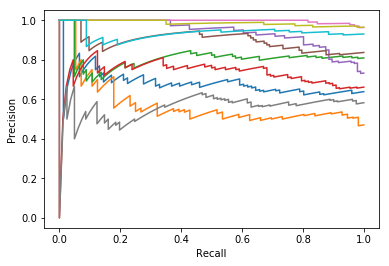

In [29]:
fig, ax = plt.subplots()
plt.xlabel("Recall")
plt.ylabel("Precision")

for product in top_ten:
    t = valence_final_results.loc[product, 'num_topics']
    regression_results.loc[product, 'num_topics_valence']=t
    test_pdct = regression_df[regression_df['ProductId']==product]

    X = test_pdct[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    y = test_pdct['Sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    pred = clf.predict(X_test)
    pred_prob = clf.predict_proba(X_test)[:,1]
    regression_results.loc[product, 'accuracy_topics_valence'] = accuracy
    print('Product: {}'.format(product), 'Num topics: {}'.format(t), "Accuracy Score: {}".format(accuracy))
    
    
    p,r,_ = precision_recall_curve(y_test, pred_prob)
    plt.plot(r, p, label=product)

    
    print(classification_report(y_test, pred))

The results are pretty varied - for some products the topic mixture is quite powerful in predicting the sentiment, for others it's not as good (even performing worse than a random guess in the case of product B006MONQMC). Visually, it looks like there could be some relationship between number of topics and accuracy of the logistic regression model - maybe having more topics (and thus more complexity) makes it harder to predict sentiment based on the topic models alone. 

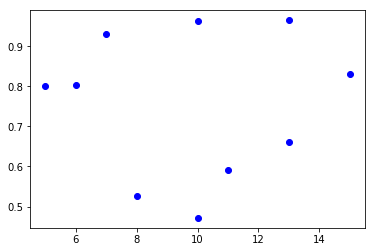

In [188]:
fig, ax = plt.subplots()
plt.plot(regression_results['num_topics_valence'], regression_results['accuracy_topics_valence'], 'bo')

In [189]:
for product in top_ten:
    t = valence_final_results.loc[product, 'num_topics']
    regression_results.loc[product, 'num_topics_valence']=t
    test_pdct = df[df['ProductId']==product]

    X = test_pdct[['valencecount_GOOD', 'valencecount_VGOOD', 'valencecount_BAD', 'valencecount_VBAD']]
    y = test_pdct['Sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    regression_results.loc[product, 'accuracy_codewords_valence'] = accuracy
    print('Product: {}'.format(product), 'Num topics: {}'.format(t), "Accuracy Score: {}".format(accuracy))

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hannahmoran/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Product: B002IEZJMA Num topics: 11 Accuracy Score: 0.7213114754098361
Product: B006MONQMC Num topics: 10 Accuracy Score: 0.6097560975609756
Product: B005ZBZLT4 Num topics: 6 Accuracy Score: 0.8188976377952756
Product: B003GTR8IO Num topics: 13 Accuracy Score: 0.706766917293233
Product: B005K4Q34S Num topics: 5 Accuracy Score: 0.8235294117647058
Product: B000NMJWZO Num topics: 10 Accuracy Score: 0.9632352941176471
Product: B0013A0QXC Num topics: 15 Accuracy Score: 0.8382352941176471
Product: B000KV61FC Num topics: 8 Accuracy Score: 0.697841726618705
Product: B001EO5Q64 Num topics: 13 Accuracy Score: 0.9647887323943662
Product: B0026RQTGE Num topics: 7 Accuracy Score: 0.9367088607594937


In [192]:
regression_results.to_csv('rating_regression_results.csv')
regression_results

num_topics  accuracy_topics_coded  accuracy_codewords  \
Unnamed: 0                                                          
B002IEZJMA          10               0.622951            0.721311   
B006MONQMC          12               0.487805            0.609756   
B005ZBZLT4          12               0.803150            0.842520   
B003GTR8IO          12               0.661654            0.714286   
B005K4Q34S           6               0.816176            0.801471   
B0013A0QXC           8               0.830882            0.830882   
B000NMJWZO           9               0.963235            0.963235   
B000KV61FC          11               0.611511            0.647482   
B001EO5Q64           8               0.964789            0.971831   
B0026RQTGE           7               0.924051            0.936709   

            num_topics_valence  accuracy_topics_valence  \
Unnamed: 0                                                
B002IEZJMA                11.0                 0.590164   
B006MONQMC                10.0                 0.471545   
B005ZBZLT4                 6.0                 0.803150   
B003GTR8IO                13.0                 0.661654   
B005K4Q34S                 5.0                 0.801471   
B0013A0QXC                15.0                 0.830882   
B000NMJWZO                10.0                 0.963235   
B000KV61FC                 8.0                 0.525180   
B001EO5Q64                13.0                 0.964789   
B0026RQTGE                 7.0                 0.930380   

            accuracy_codewords_valence  
Unnamed: 0                              
B002IEZJMA                    0.721311  
B006MONQMC                    0.609756  
B005ZBZLT4                    0.818898  
B003GTR8IO                    0.706767  
B005K4Q34S                    0.823529  
B0013A0QXC                    0.838235  
B000NMJWZO                    0.963235  
B000KV61FC                    0.697842  
B001EO5Q64                    0.964789  
B0026RQTGE                    0.936709

In [12]:
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, QuadgramCollocationFinder, BigramCollocationFinder, TrigramCollocationFinder
from nltk import word_tokenize, FreqDist, bigrams
import operator
import pickle

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, LabelSet, Jitter, HoverTool
from bokeh.palettes import GnBu3, OrRd3
from bokeh.core.properties import value
from bokeh.transform import dodge, jitter
from bokeh.layouts import gridplot

output_notebook()

with open("trigrams_filter.txt", "rb") as f:
    trigrams_filter = pickle.load(f)
with open("bigrams_filter.txt", "rb") as f:
    bigrams_filter = pickle.load(f)

Loading BokehJS ...

In [21]:
# helper functions to visualize topics per product


def bigrams_by_sent(df, top_bigram, text_input, topic):  
    bigram_measures = BigramAssocMeasures()
    try:
        words = np.concatenate(np.array([word_tokenize(r) for r in df[text_input].values]))
        bigram_fd = FreqDist(bigrams(words))

        finder = BigramCollocationFinder.from_words(words, window_size=3)
        finder.apply_word_filter(lambda w: w in ('GOODREVIEW', 'BADREVIEW', 'VGOODREVIEW', 'VBADREVIEW', 's',
                                                    'b', 'c', 'oz', 'be'))

        finder.apply_freq_filter(3)
        finder.apply_ngram_filter(lambda w1, w2: (w1, w2) in bigrams_filter)
        top_bigrams = finder.nbest(bigram_measures.pmi, 6)
        grams=[]
        if top_bigram in top_bigrams:
            for a in top_bigrams:
                if a != top_bigram:
                    grams.append(a[0]+" "+a[1])
        else:
            grams = [a[0]+" "+a[1] for a in top_bigrams]
        chi_sq_raw = dict(finder.score_ngrams(bigram_measures.chi_sq))
        raw_freq = dict(finder.score_ngrams(bigram_measures.raw_freq))
        pmi_raw = dict(finder.score_ngrams(bigram_measures.pmi))
        # use PMI as a filter - only keep bigrams with a positive PMI score (indicates positive association)
        # use chi_sq as a filter - only want bigrams that pass the significance threshold of 3.841
        pmi = {k:v for (k,v) in pmi_raw.items() if v > 0}
        chi_sq = {k:v for (k,v) in chi_sq_raw.items() if v >3.841}
    except ValueError:
        grams = []
        pmi = []
        chi_sq = []
        raw_freq = []
    pmi = pd.Series(pmi)
    chi_sq = pd.Series(chi_sq).apply(np.log)
    raw_freq=pd.Series(raw_freq)

    gram_df = pd.concat([pmi, chi_sq, raw_freq], axis=1).reset_index()
    gram_df.rename(columns={0: 'pmi', 1:'chi_sq', 2:'raw_freq'}, inplace=True)
    gram_df['topic'] = "Topic {}".format(topic)
    try:
        gram_df['bigram'] = gram_df['level_0']+" "+gram_df['level_1']
        gram_df['bigram'] = gram_df['bigram'].apply(lambda x: tuple(list(x.split())))
        gram_df = gram_df[['pmi', 'chi_sq', 'raw_freq', 'topic', 'bigram']]
    except KeyError:
        if gram_df.empty:
            gram_df = pd.DataFrame(columns=['pmi', 'chi_sq', 'raw_freq', 'topic','bigram'])
        else:
            print("Other error with building bigrams dataframe.")
    return grams, gram_df

def get_bigrams(product, topic, text_input, top_bigram):

    topic_df = sub_df_ten.loc[(sub_df_ten["ProductId"]==product)&(sub_df_ten['max_topic']==topic)]
    pos_df = topic_df[topic_df['Sentiment']==1]
    neg_df = topic_df[topic_df['Sentiment']==0]
    bigram_measures = BigramAssocMeasures()

    grams_pos, pos_bg_df = bigrams_by_sent(pos_df, top_bigram, text_input, topic)
    pos_bg_df['sent']='positive'
    grams_neg, neg_bg_df = bigrams_by_sent(neg_df, top_bigram, text_input, topic)
    neg_bg_df['sent']='negative'

    return grams_pos, grams_neg, pos_bg_df, neg_bg_df



def vis_topics_sent(product, text_input):
    product_df = sub_df_ten.loc[sub_df_ten['ProductId']==product]
    topic_counts = product_df['max_topic'].value_counts().to_dict()
    topics = ['Topic {}'.format(t) for t in sorted(topic_counts)]
    counts = [topic_counts[t] for t in sorted(topic_counts)]
    product_words = np.concatenate(np.array([word_tokenize(r) for r in product_df[text_input].values]))
    sentiments = ["Positive", "Negative"]
    pos_counts = []
    neg_counts = []
    for t in sorted(topic_counts):
        topic_df = product_df[product_df['max_topic']==t]
        sent_counts = topic_df['Sentiment'].value_counts()
        try:
            pos_counts.append(sent_counts.loc[1])
        except KeyError:
            pos_counts.append(0)
        try: 
            neg_counts.append(sent_counts.loc[0])
        except KeyError:
            neg_counts.append(0)
    
    bigram_fd = FreqDist(bigrams(product_words))
    top_bigram = max(bigram_fd.items(), key=operator.itemgetter(1))[0]
    gram_list_pos = []
    gram_list_neg = []

    bg_df = pd.DataFrame(columns=['topic','pmi', 'chi_sq', 'raw_freq', 'bigram', 'sent'])
    for t in sorted(topic_counts):
        grams_pos, grams_neg, pos_bg_df, neg_bg_df = get_bigrams(product=product, text_input=text_input, 
                                                                 topic=t, top_bigram=top_bigram)
        bg_df = pd.concat([pos_bg_df, bg_df], axis=0)
        bg_df = pd.concat([neg_bg_df, bg_df], axis=0)
        gram_list_pos.append(grams_pos)
        gram_list_neg.append(grams_neg)
    
    colormap = {'negative': 'red', 'positive': 'blue'}

    bg_df['color'] = bg_df['sent'].map(lambda x: colormap[x])
    source2 = ColumnDataSource(data=bg_df) # for right chart
    source1 = ColumnDataSource(data={'topics': topics, # for left chart
           'Positive': pos_counts,
           'Negative': neg_counts,
           'counts': counts,
            'labels_pos': gram_list_pos,
            'labels_neg': gram_list_neg
           })
    
    # build the lefthand chart to show review counts by topic and by review sentiment
    left = figure(y_range=topics, x_range=(0, 1000), plot_height=500, \
               title="Topic Outputs by Review Sentiment for Product {}".format(product), toolbar_location=None, tools="")
    left.hbar(y=dodge('topics', -0.25, range=left.y_range), right='Positive', height=0.2, source=source1,
           color="#718dbf", legend=value("Positive Reviews"))

    left.hbar(y=dodge('topics',  0.0,  range=left.y_range), right='Negative', height=0.2, source=source1,
           color="#e84d60", legend=value("Negative Reviews"))

    left.y_range.range_padding = 0.1
    left.ygrid.grid_line_color = None
    left.legend.location = "bottom_right"
    left.legend.orientation = "vertical"
    
    labels1 = LabelSet(y='topics', x='Positive', text='labels_pos', source=source1, level='glyph', render_mode='canvas',
                     x_offset=5, y_offset=-20, text_font_size="8pt")
    labels2 = LabelSet(y='topics', x='Negative', text='labels_neg', source=source1, level='glyph', render_mode='canvas',
                     x_offset=5, y_offset=0, text_font_size="8pt")
    left.xaxis.axis_label = 'Number of Reviews'

    left.add_layout(labels1)
    left.add_layout(labels2)
    
  
    # set up the righthand chart of the bigrams
    right = figure(y_range=topics, plot_height=500, title="Bigrams by Review Sentiment for Product {}".format(product),
                  toolbar_location=None, tools="")
    # split out and plot negative- and positive-review-associated bigrams separately
    # so they can be hidden via interactive legend
    df_pos = bg_df[bg_df['color']=='blue']
    df_neg = bg_df[bg_df['color']=='red']
    source_pos = ColumnDataSource(df_pos)
    source_neg = ColumnDataSource(df_neg)
    r_pos = right.circle(x='chi_sq', y=jitter('topic', width=0.3, range=right.y_range), fill_color='color', line_color='color',
                 source=source_pos, fill_alpha=0.3, legend='sent', muted_color='color', muted_alpha=0.2,)
    r_neg = right.circle(x='chi_sq', y=jitter('topic', width=0.3, range=right.y_range), fill_color='color', line_color='color',
             source=source_neg, fill_alpha=0.3, legend='sent', muted_color='color', muted_alpha=0.2)
    right.add_tools(HoverTool(renderers=[r_neg], tooltips=[("bigram","@bigram"), ("score","@chi_sq")]))
    right.add_tools(HoverTool(renderers=[r_pos], tooltips=[("bigram","@bigram"), ("score","@chi_sq")]))

    right.xaxis.axis_label = "Log of Chi-Squared Score"
    right.legend.click_policy="hide"
    
    p = gridplot([[left, right]])
    return p



In [22]:
for product in top_ten:
    p = vis_topics_sent(product, 'clean_coded')
    show(p)

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:100: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



array(['B002IEZJMA', 'B006MONQMC', 'B005ZBZLT4', 'B003GTR8IO',
       'B005K4Q34S', 'B000NMJWZO', 'B0013A0QXC', 'B000KV61FC',
       'B001EO5Q64', 'B0026RQTGE'], dtype=object)

In [218]:


def get_bigram_scores(topic_words):
    bigram_fd = FreqDist(bigrams(topic_words))
    finder = BigramCollocationFinder.from_words(topic_words)
    finder.apply_word_filter(lambda w: w in ('GOODREVIEW', 'BADREVIEW', 'VGOODREVIEW', 'VBADREVIEW', 's',
                                                    'b', 'c', 'oz', 'be'))

    finder.apply_freq_filter(3)
    finder.apply_ngram_filter(lambda w1, w2: (w1, w2) in bigrams_filter)
    chi_sq = dict(finder.score_ngrams(bigram_measures.chi_sq))
    raw_freq = dict(finder.score_ngrams(bigram_measures.raw_freq))
    pmi_raw = dict(finder.score_ngrams(bigram_measures.pmi))
    # use PMI as a filter - only keep bigrams with a positive PMI score (indicates positive association)
    pmi = {k:v for (k,v) in pmi_raw.items() if v > 0}
    return pmi, chi_sq, raw_freq



In [221]:
from nltk import bigrams, BigramAssocMeasures
def plot_bigram_scores(product):
    bigram_measures = BigramAssocMeasures()
    product_df = sub_df_ten[sub_df_ten["ProductId"]==product]
    product_words = np.concatenate(np.array([word_tokenize(r) for r in product_df['clean_coded'].values]))
    pmi, chi_sq, raw_freq = get_bigram_scores(product_words)
    all_bgs = sorted(pmi)
    chi_sqs = [chi_sq[b] for b in all_bgs]
    raw_freqs = [raw_freq[b]*100 for b in all_bgs]
    
    p = figure()
    source = ColumnDataSource(data=dict(all_bgs=all_bgs,
                                        chi_sqs=chi_sqs,
                                        raw_freqs=raw_freqs))
    p.scatter(x=chi_sqs, y=raw_freqs, radius=0.5)
    p.xaxis[0].axis_label = 'log of Chi squared score'
    p.yaxis[0].axis_label = 'log Raw Frequency'
    labels = LabelSet(x = 'chi_sqs', y='raw_freqs', text='all_bgs', source=source, level='glyph', render_mode='canvas')
    p.add_layout(labels)
    return p

In [223]:
p = plot_bigram_scores('B005ZBZLT4')
show(p)

In [163]:
from math import log, sqrt


In [192]:
all_bgs = sorted(pmi)
chi_sqs = [sqrt(chi_sq[b]) for b in all_bgs]
raw_freqs = [log(raw_freq[b]) for b in all_bgs]

In [193]:
print(len(all_bgs), len(chi_sqs), len(raw_freqs))

1865 1865 1865


In [177]:
bigram_measures = BigramAssocMeasures()
product_df = sub_df_ten[sub_df_ten["ProductId"]=='B006MONQMC']
product_words = np.concatenate(np.array([word_tokenize(r) for r in product_df['clean_coded'].values]))
finder = BigramCollocationFinder.from_words(product_words)
finder.apply_word_filter(lambda w: w in ('GOODREVIEW', 'BADREVIEW', 'VGOODREVIEW', 'VBADREVIEW', 's',
                                                'b', 'c', 'oz', 'be'))

finder.apply_freq_filter(3)
finder.apply_ngram_filter(lambda w1, w2: (w1, w2) in bigrams_filter)
chi_sq = dict(finder.score_ngrams(bigram_measures.chi_sq))
raw_freq = dict(finder.score_ngrams(bigram_measures.raw_freq))
pmi_raw = dict(finder.score_ngrams(bigram_measures.pmi))
# use PMI as a filter - only keep bigrams with a positive PMI score (indicates positive association)
pmi = {k:v for (k,v) in pmi_raw.items() if v > 0}

In [184]:
len(chi_sqs)

1865

In [170]:
p = figure()
source = ColumnDataSource(data=dict(all_bgs=all_bgs,
                                    pmi_scores=pmi_scores,
                                    raw_freqs=raw_freqs))
p.scatter(x=pmi_scores, y=raw_freqs, radius=1)
p.xaxis[0].axis_label = 'square root of PMI score'
p.yaxis[0].axis_label = 'log Raw Frequency'
labels = LabelSet(x = 'pmi_scores', y='raw_freqs', text='all_bgs', source=source, level='glyph', render_mode='canvas')
p.add_layout(labels)
show(p)

In [66]:
ignored_words = ['BADREVIEW', 'VBADREVIEW', 'GOODREVIEW', 'VGOODREVIEW']
finder.apply_word_filter(lambda w: len(w) < 3 or w in ignored_words)
#finder.nbest(bigram_measures.likelihood_ratio, 10)
finder.nbest(bigram_measures.pmi, 10)

[('medium', 'chain'),
 ('cardiovascular', 'disease'),
 ('replace', 'saturate'),
 ('chain', 'saturate'),
 ('coconut', 'oil'),
 ('saturated', 'fat'),
 ('saturate', 'fat')]

In [93]:
trigrams_filter

[('does', 'not', 'have'),
 ('did', 'not', 'hav'),
 ('do', 'not', 'have'),
 ('can', 'not', 'have'),
 ('have', 'not', 'been'),
 ('do', 'not', 'know'),
 ('do', 'not', 'like'),
 ('do', 'not', 'feel'),
 ('do', 'not', 'get'),
 ('do', 'not', 'leave'),
 ('do', 'not', 'want'),
 ('do', 'not', 'work'),
 ('have', 'not', 'use')]

In [37]:
finder.nbest(bigram_measures.chi_sq, 30) 

[('subscribe', 'save'),
 ('extra', 'virgin'),
 ('anti', 'bacterial'),
 ('saturated', 'fat'),
 ('diaper', 'rash'),
 ('coconut', 'oil'),
 ('before', 'bed'),
 ('stir', 'fry'),
 ('health', 'benefit'),
 ('highly', 'recommend'),
 ('many', 'us'),
 ('high', 'heat'),
 ('after', 'shower'),
 ('place', 'butter'),
 ('small', 'container'),
 ('year', 'old'),
 ('must', 'say'),
 ('nutiva', 'organic'),
 ('scoop', 'out'),
 ('turn', 'out'),
 ('so', 'far'),
 ('every', 'day'),
 ('glass', 'jar'),
 ('decide', 'give'),
 ('plastic', 'container'),
 ('few', 'week'),
 ('olive', 'oil'),
 ('next', 'time'),
 ('one', 'kitchen'),
 ('think', 'would')]

In [97]:
trigram_measures = TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(test_pdct_words)
#finder = TrigramCollocationFinder.from_words(test_pdct_words, window_size=5)

trigrams_filter = [('does', 'not', 'have'), ('did', 'not', 'hav'), ('do', 'not', 'have'), ('can', 'not', 'have'), 
                   ('have', 'not', 'been'), ('do', 'not', 'know'), ('do', 'not', 'like'), ('do', 'not', 'feel'), ('do', 'not', 'get'),
                  ('do', 'not', 'leave'), ('do', 'not', 'want'), ('do', 'not', 'work')]
finder.apply_ngram_filter(lambda w1, w2, w3: (w1, w2, w3) in trigrams_filter)
finder.apply_word_filter(lambda w: w in ('GOODREVIEW', 'BADREVIEW', 'be', 'coconut', 'oil'))


finder.apply_freq_filter(4) 
#sorted(finder.nbest(trigram_measures.chi_sq, 30))
sorted(finder.nbest(trigram_measures.raw_freq, 30))

NameError: name 'test_pdct_words' is not defined

In [61]:
ignored_words = ['BADREVIEW', 'VBADREVIEW', 'GOODREVIEW', 'VGOODREVIEW']
finder.apply_word_filter(lambda w: len(w) < 4 or w in ignored_words)
finder.nbest(trigram_measures.raw_freq, 10)

[('organic', 'extra', 'virgin'),
 ('nutiva', 'organic', 'extra'),
 ('health', 'food', 'store'),
 ('many', 'health', 'benefit')]

In [49]:
from nltk.metrics.association import QuadgramAssocMeasures

quadgram_measures = QuadgramAssocMeasures()
finder = QuadgramCollocationFinder.from_words(test_pdct_words)
#finder = QuadgramCollocationFinder.from_words(test_pdct_words, window_size=5)
finder.apply_word_filter(lambda w: w in ('VGOODREVIEW', 'GOODREVIEW', 'BADREVIEW', 'VBADREVIEW', 'be', 'coconut', 'oil'))
finder.apply_freq_filter(4) 
sorted(finder.nbest(quadgram_measures.pmi, 30)) 
#sorted(finder.nbest(quadgram_measures.raw_freq, 30))

[]

In [1]:

def print_topic_coherences(product, df, final_results):
    data = df[df['ProductId']==product]
    # prepare the corpus
    texts = data['clean_valence'].str.split()
    dictionary = corpora.Dictionary(texts)
    remove_freq(dictionary, 10)
    corpus = [dictionary.doc2bow(text) for text in texts]
    # load in the tuned LDA model for the product
    t = final_results.loc[product, 'num_topics']
    p = final_results.loc[product, 'passes']
    lda = gensim.models.ldamodel.LdaModel.load("./valence_outputs/final_models/{}_{}_{}".format(product, t, p))
    print("Topic Coherences for Product {}".format(product))

    
    for n, topic in lda.show_topics(formatted=False):
        print(n)
        topic = [word for word, _ in topic]
        cm = CoherenceModel(topics=[topic], texts=texts, dictionary=dictionary, window_size=2, coherence='u_mass')
        coh = cm.get_coherence()
        print(coh)


    

In [85]:
for product in top_ten:
    print_topic_coherences(product, df, valence_final_results)

2018-06-28 15:50:23,078 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-28 15:50:23,257 : INFO : built Dictionary(2971 unique tokens: ['somewhat', 'goodness', 'gkass', 'open', 'kashered']...) from 487 documents (total 41120 corpus positions)
2018-06-28 15:50:23,274 : INFO : discarding 10 tokens: [('be', 478), ('coffee', 444), ('not', 397), ('drink', 372), ('have', 329), ('like', 325), ('taste', 316), ('do', 278), ('flavor', 232), ('good', 211)]...
2018-06-28 15:50:23,295 : INFO : resulting dictionary: Dictionary(2961 unique tokens: ['somewhat', 'goodness', 'gkass', 'open', 'kashered']...)
2018-06-28 15:50:23,435 : INFO : loading LdaModel object from ./valence_outputs/final_models/B002IEZJMA_11_80
2018-06-28 15:50:23,444 : INFO : loading expElogbeta from ./valence_outputs/final_models/B002IEZJMA_11_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:23,452 : INFO : setting ignored attribute state to None
2018-06-28 15:50:23,454 : INFO : setting ignored attribute id

Topic Coherences for Product B002IEZJMA
9
-0.946636804682416
3
-14.854045099535954
10
-15.633998393146365
5
-11.230680373149394
1
-16.957575372499573
8
-1.5356145282353328
2
-0.8858465291137495
7
-18.837347501733902
4
-1.683471904615551
6


2018-06-28 15:50:25,036 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


-8.103814852788968


2018-06-28 15:50:25,277 : INFO : built Dictionary(3449 unique tokens: ['utility', 'somewhat', 'beware', 'goodness', 'open']...) from 491 documents (total 54341 corpus positions)
2018-06-28 15:50:25,297 : INFO : discarding 10 tokens: [('be', 480), ('not', 422), ('water', 394), ('taste', 383), ('vitamin', 366), ('have', 364), ('do', 358), ('drink', 356), ('like', 347), ('flavor', 321)]...
2018-06-28 15:50:25,313 : INFO : resulting dictionary: Dictionary(3439 unique tokens: ['utility', 'somewhat', 'beware', 'goodness', 'open']...)
2018-06-28 15:50:25,471 : INFO : loading LdaModel object from ./valence_outputs/final_models/B006MONQMC_10_80
2018-06-28 15:50:25,479 : INFO : loading expElogbeta from ./valence_outputs/final_models/B006MONQMC_10_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:25,486 : INFO : setting ignored attribute state to None
2018-06-28 15:50:25,489 : INFO : setting ignored attribute id2word to None
2018-06-28 15:50:25,492 : INFO : setting ignored attribute dispatcher t

Topic Coherences for Product B006MONQMC
0
-10.632842067405063
1
-16.789394304259556
2
-15.794991860014731
3
-14.531778816177535
4
-17.472133179110283
5
-21.098632941537332
6
-12.12088075672743
7
-18.91919769362776
8
-0.5889699672294871
9


2018-06-28 15:50:27,297 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-28 15:50:27,430 : INFO : built Dictionary(2464 unique tokens: ['coarser', 'officially', 'limit', 'fit', 'complete']...) from 506 documents (total 30905 corpus positions)
2018-06-28 15:50:27,442 : INFO : discarding 10 tokens: [('be', 463), ('coffee', 445), ('cup', 363), ('not', 298), ('have', 283), ('k', 265), ('like', 209), ('good', 203), ('taste', 193), ('do', 183)]...
2018-06-28 15:50:27,456 : INFO : resulting dictionary: Dictionary(2454 unique tokens: ['coarser', 'officially', 'limit', 'fit', 'complete']...)


-0.7883220894811256


2018-06-28 15:50:27,555 : INFO : loading LdaModel object from ./valence_outputs/final_models/B005ZBZLT4_6_80
2018-06-28 15:50:27,560 : INFO : loading expElogbeta from ./valence_outputs/final_models/B005ZBZLT4_6_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:27,565 : INFO : setting ignored attribute state to None
2018-06-28 15:50:27,569 : INFO : setting ignored attribute id2word to None
2018-06-28 15:50:27,570 : INFO : setting ignored attribute dispatcher to None
2018-06-28 15:50:27,572 : INFO : loaded ./valence_outputs/final_models/B005ZBZLT4_6_80
2018-06-28 15:50:27,575 : INFO : loading LdaState object from ./valence_outputs/final_models/B005ZBZLT4_6_80.state
2018-06-28 15:50:27,583 : INFO : loaded ./valence_outputs/final_models/B005ZBZLT4_6_80.state


Topic Coherences for Product B005ZBZLT4
0
-15.684437997304425
1
-1.5284419670648728
2
-1.1295972926692421
3
-2.4966076963150914
4


2018-06-28 15:50:28,279 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


-0.9709188382451703
5
-15.429354720869371


2018-06-28 15:50:28,462 : INFO : built Dictionary(3165 unique tokens: ['nauseate', 'somewhat', 'beware', 'goodness', 'open']...) from 530 documents (total 47454 corpus positions)
2018-06-28 15:50:28,475 : INFO : discarding 10 tokens: [('coffee', 518), ('be', 509), ('vanilla', 474), ('not', 451), ('flavor', 398), ('taste', 383), ('starbucks', 371), ('have', 353), ('do', 318), ('like', 310)]...
2018-06-28 15:50:28,492 : INFO : resulting dictionary: Dictionary(3155 unique tokens: ['nauseate', 'somewhat', 'beware', 'goodness', 'open']...)
2018-06-28 15:50:28,631 : INFO : loading LdaModel object from ./valence_outputs/final_models/B003GTR8IO_13_80
2018-06-28 15:50:28,638 : INFO : loading expElogbeta from ./valence_outputs/final_models/B003GTR8IO_13_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:28,645 : INFO : setting ignored attribute state to None
2018-06-28 15:50:28,647 : INFO : setting ignored attribute id2word to None
2018-06-28 15:50:28,649 : INFO : setting ignored attribute dispa

Topic Coherences for Product B003GTR8IO
7
-12.346197342252877
1
-1.3560997312948333
3
-0.9678504774721657
12
-14.447034445305361
4
-17.597504168932264
8
-3.21926813899509
6
-16.580185957343314
2
-16.557175809194593
11
-0.917611792531346
0


2018-06-28 15:50:30,155 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-28 15:50:30,267 : INFO : built Dictionary(1863 unique tokens: ['limit', 'fit', 'somewhat', 'beware', 'recall']...) from 541 documents (total 19612 corpus positions)
2018-06-28 15:50:30,282 : INFO : discarding 10 tokens: [('be', 478), ('not', 297), ('coffee', 254), ('have', 253), ('cup', 243), ('taste', 232), ('cappuccino', 210), ('like', 204), ('do', 181), ('good', 150)]...


-14.859377497537107


2018-06-28 15:50:30,295 : INFO : resulting dictionary: Dictionary(1853 unique tokens: ['limit', 'fit', 'somewhat', 'beware', 'goodness']...)
2018-06-28 15:50:30,362 : INFO : loading LdaModel object from ./valence_outputs/final_models/B005K4Q34S_5_80
2018-06-28 15:50:30,367 : INFO : loading expElogbeta from ./valence_outputs/final_models/B005K4Q34S_5_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:30,374 : INFO : setting ignored attribute state to None
2018-06-28 15:50:30,377 : INFO : setting ignored attribute id2word to None
2018-06-28 15:50:30,380 : INFO : setting ignored attribute dispatcher to None
2018-06-28 15:50:30,385 : INFO : loaded ./valence_outputs/final_models/B005K4Q34S_5_80
2018-06-28 15:50:30,388 : INFO : loading LdaState object from ./valence_outputs/final_models/B005K4Q34S_5_80.state
2018-06-28 15:50:30,396 : INFO : loaded ./valence_outputs/final_models/B005K4Q34S_5_80.state


Topic Coherences for Product B005K4Q34S
0
-2.1285475479482394
1
-1.5561711078473761
2


2018-06-28 15:50:30,816 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


-2.3879591415859096
3
-19.835603625599052
4
-1.3273341410265476


2018-06-28 15:50:30,938 : INFO : built Dictionary(2214 unique tokens: ['zero', 'fit', 'amazing', 'beware', 'goodness']...) from 542 documents (total 27583 corpus positions)
2018-06-28 15:50:30,949 : INFO : discarding 10 tokens: [('be', 502), ('mix', 375), ('have', 373), ('pancake', 365), ('gluten', 333), ('make', 322), ('free', 301), ('not', 260), ('use', 257), ('s', 228)]...
2018-06-28 15:50:30,955 : INFO : resulting dictionary: Dictionary(2204 unique tokens: ['zero', 'fit', 'amazing', 'beware', 'goodness']...)
2018-06-28 15:50:31,048 : INFO : loading LdaModel object from ./valence_outputs/final_models/B000NMJWZO_10_80
2018-06-28 15:50:31,056 : INFO : loading expElogbeta from ./valence_outputs/final_models/B000NMJWZO_10_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:31,062 : INFO : setting ignored attribute state to None
2018-06-28 15:50:31,065 : INFO : setting ignored attribute id2word to None
2018-06-28 15:50:31,068 : INFO : setting ignored attribute dispatcher to None
2018-06-2

Topic Coherences for Product B000NMJWZO
0
-18.198911917116614
1
-1.5311976757338956
2
-1.2397852604462867
3
-11.7477200772442
4
-1.7656147866750227
5
-13.515656599131358
6
-16.261305454654266
7
-2.0161487838735153
8
-16.329092432347604
9


2018-06-28 15:50:32,182 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-28 15:50:32,297 : INFO : built Dictionary(2167 unique tokens: ['limit', 'fit', 'somewhat', 'recall', 'open']...) from 542 documents (total 22866 corpus positions)
2018-06-28 15:50:32,307 : INFO : discarding 10 tokens: [('be', 486), ('coffee', 434), ('senseo', 318), ('have', 294), ('pod', 282), ('not', 220), ('cup', 176), ('good', 175), ('so', 142), ('use', 138)]...


-14.260618433687544


2018-06-28 15:50:32,319 : INFO : resulting dictionary: Dictionary(2157 unique tokens: ['limit', 'fit', 'somewhat', 'recall', 'league']...)
2018-06-28 15:50:32,399 : INFO : loading LdaModel object from ./valence_outputs/final_models/B0013A0QXC_15_80
2018-06-28 15:50:32,404 : INFO : loading expElogbeta from ./valence_outputs/final_models/B0013A0QXC_15_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:32,411 : INFO : setting ignored attribute state to None
2018-06-28 15:50:32,413 : INFO : setting ignored attribute id2word to None
2018-06-28 15:50:32,417 : INFO : setting ignored attribute dispatcher to None
2018-06-28 15:50:32,420 : INFO : loaded ./valence_outputs/final_models/B0013A0QXC_15_80
2018-06-28 15:50:32,422 : INFO : loading LdaState object from ./valence_outputs/final_models/B0013A0QXC_15_80.state
2018-06-28 15:50:32,432 : INFO : loaded ./valence_outputs/final_models/B0013A0QXC_15_80.state


Topic Coherences for Product B0013A0QXC
3
-2.1728863123589934
2
-7.401708951756727
8
-1.4718585835713305
7
-1.551631136408113
14
-2.8317397643526685
9
-6.460442198413016
11
-17.334298631658356
12
-14.338265029707781
1


2018-06-28 15:50:33,484 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


-10.255901599261014
6
-15.206705030236638


2018-06-28 15:50:33,684 : INFO : built Dictionary(2842 unique tokens: ['somebody', 'somewhat', 'goodness', 'open', 'collie']...) from 556 documents (total 38323 corpus positions)
2018-06-28 15:50:33,701 : INFO : discarding 10 tokens: [('be', 506), ('toy', 409), ('dog', 398), ('have', 381), ('not', 359), ('get', 350), ('out', 342), ('do', 284), ('treat', 274), ('rope', 243)]...
2018-06-28 15:50:33,717 : INFO : resulting dictionary: Dictionary(2832 unique tokens: ['somebody', 'somewhat', 'goodness', 'open', 'collie']...)
2018-06-28 15:50:33,858 : INFO : loading LdaModel object from ./valence_outputs/final_models/B000KV61FC_8_80
2018-06-28 15:50:33,863 : INFO : loading expElogbeta from ./valence_outputs/final_models/B000KV61FC_8_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:33,868 : INFO : setting ignored attribute state to None
2018-06-28 15:50:33,872 : INFO : setting ignored attribute id2word to None
2018-06-28 15:50:33,875 : INFO : setting ignored attribute dispatcher to None
2018

Topic Coherences for Product B000KV61FC
0
-1.2253309475911858
1
-9.806882122060971
2
-16.84534685725071
3
-14.898379782625701
4
-13.986435303113133
5
-1.346804937305385
6
-1.0984304904477695
7
-13.847803177802097


2018-06-28 15:50:35,014 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-28 15:50:35,193 : INFO : built Dictionary(3244 unique tokens: ['gunky', 'somewhat', 'beware', 'goodness', 'open']...) from 567 documents (total 35943 corpus positions)
2018-06-28 15:50:35,211 : INFO : discarding 10 tokens: [('be', 504), ('oil', 428), ('use', 395), ('coconut', 390), ('have', 329), ('not', 280), ('great', 231), ('so', 212), ('good', 191), ('do', 189)]...
2018-06-28 15:50:35,230 : INFO : resulting dictionary: Dictionary(3234 unique tokens: ['somewhat', 'beware', 'goodness', 'open', 'carribean']...)
2018-06-28 15:50:35,361 : INFO : loading LdaModel object from ./valence_outputs/final_models/B001EO5Q64_13_80
2018-06-28 15:50:35,367 : INFO : loading expElogbeta from ./valence_outputs/final_models/B001EO5Q64_13_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:35,373 : INFO : setting ignored attribute state to None
2018-06-28 15:50:35,379 : INFO : setting ignored attribute id2word 

Topic Coherences for Product B001EO5Q64
4
-5.23104939124564
2
-1.4681478009009408
9
-11.45388415418666
10
-14.23197088746595
7
-1.2814298608355874
1
-15.210823958570584
12
-17.019865838252613
11
-1.8657874755784254
8


2018-06-28 15:50:37,316 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


-16.354446460001235
6
-1.7942002897817755


2018-06-28 15:50:37,447 : INFO : built Dictionary(2543 unique tokens: ['limit', 'fit', 'somewhat', 'beware', 'goodness']...) from 630 documents (total 25518 corpus positions)
2018-06-28 15:50:37,459 : INFO : discarding 10 tokens: [('be', 547), ('dog', 463), ('love', 343), ('have', 334), ('greenies', 318), ('not', 235), ('treat', 227), ('do', 224), ('teeth', 221), ('get', 207)]...
2018-06-28 15:50:37,471 : INFO : resulting dictionary: Dictionary(2533 unique tokens: ['limit', 'fit', 'somewhat', 'beware', 'goodness']...)
2018-06-28 15:50:37,564 : INFO : loading LdaModel object from ./valence_outputs/final_models/B0026RQTGE_7_80
2018-06-28 15:50:37,574 : INFO : loading expElogbeta from ./valence_outputs/final_models/B0026RQTGE_7_80.expElogbeta.npy with mmap=None
2018-06-28 15:50:37,579 : INFO : setting ignored attribute state to None
2018-06-28 15:50:37,581 : INFO : setting ignored attribute id2word to None
2018-06-28 15:50:37,583 : INFO : setting ignored attribute dispatcher to None
2018-

Topic Coherences for Product B0026RQTGE
0
-2.2339351290800233
1
-12.330288084685183
2
-1.5715317058982767
3
-1.4205473997732159
4
-1.3002030615022035
5
-11.080392271310675
6
-14.863195598947229
